# Classifying AI-Generated vs. Human Text Using LSTMs
---
Itzhak Estrella , Monique Tran mkt973

## Library Imports

In [2]:
from IPython.display import display
from scipy.stats import norm
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import langdetect
from langdetect import detect
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, LeakyReLU
from keras.layers import Bidirectional
from keras.layers import Bidirectional, LSTM, GRU, Dense, Embedding, LayerNormalization

SEED = 5
random.seed(SEED)

## 1. Data Preprocessing

Let's read in the data. First, let's print a little more information about the data. We can see that we have five different features, where `text` is the text that is either written or generated, `source` is who/what created the text, `prompt_id` corresponds to another csv file that contains what prompt was used for the text (which we will ignore), `text_length` is the number of characters in the text, and `word_count` is the number of words in the text.

In [3]:
file_path = 'data.csv'
text_df = pd.read_csv(file_path)
text_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 788922 entries, 0 to 788921
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   text         788922 non-null  object
 1   source       788922 non-null  object
 2   prompt_id    788922 non-null  int64 
 3   text_length  788922 non-null  int64 
 4   word_count   788922 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 30.1+ MB


Let's take a look at what the entries in this dataset look like.

In [4]:
display(text_df.head())

,text,source,prompt_id,text_length,word_count
0,"Federal law supersedes state law, and cannabis...",Bloom-7B,0,967,157
1,Miles feels restless after working all day. He...,Bloom-7B,0,5068,778
2,So first of I am danish. That means that I fol...,Bloom-7B,0,1602,267
3,In this paper we present a novel rule-based ap...,Bloom-7B,0,5469,848
4,"Most social progressives, love democracy, and ...",Bloom-7B,0,2379,380


Let's see if there are any null values in the dataset.

In [5]:
print(f'Null count: {text_df.isnull().sum().sum()}')

Null count: 0


As we can see, our dataset contains 0 null values, therefore we don't need to worry about missing data. However, we aren't sure if all the provided text that will be used to train the LTSM model is in English. We will use the `langdetect` library (provided by Google) to detect the language of the text and remove any non-English text. First, let us limit our data to the essay lengths we want to consider: essays between 250-5000 words. We can see that with this modification, we ended up removing 340,503 entries and now have a final dataset size with 448,419 entries. We will do this first to reduce computational cost in time.

In [6]:
print('Shape of text_df:', text_df.shape)
text_df = text_df[(text_df['word_count'] >= 250) & (text_df['word_count'] <= 5_000)]
# reset indexing to avoid confusion
text_df.reset_index(drop=True, inplace=True)

print('Shape of text_no_outliers:', text_df.shape)
print('Entry Difference:', text_df.shape[0] - text_df.shape[0])

Shape of text_df: (788922, 5)
Shape of text_no_outliers: (449236, 5)
Entry Difference: 0


Now, let us gather into lists all the non-English and other oddity entries so that we can remove them later and print each of these entries.

In [7]:
# gather all non english and any other odd entries
non_english = 0
non_english_entries = list()
exception_entries = list()
for i, row in text_df.iterrows():
    try:
        if detect(row['text']) != 'en':
            non_english += 1
            non_english_entries.append(i)
    except:
        exception_entries.append(i)
print(f'Non-English text entries: {non_english}')
print(f'Non-English entries: {non_english_entries}')
print(f'Exception entries: {exception_entries}')

If we print one of the non-English entries, we can see that it's in French, so we successfully located the non-English entries.

In [9]:
print(text_df.iloc[410]['text'])

Une personne qui travaille a proximite d'Akemi m'avait recommande l'endroit. Je n'y suis allee qu'a une seule reprise pour acheter des sushis pour emporter et je ne crois pas que j'y retournerai. Je connais cet endroit depuis quelques annees, mais jamais encore j'y ai mange. La nourriture est excellente, le service tres accueillant (sans compter la gentillesse de l'entree!), les prix sont abordables et l'ambiance agreable! N'ayant eu l'occasion d'y aller qu'une fois, il m'est difficile d'en parler plus en detail. Toutefois j'ai vraiment ete satisfaite: produit frais au menu, personnel sympathique et chaleureux C'est un restaurant japonnais plutot bien situe dans l'arrondissement Plateau Mont-Royal. (Aveugle du Mail). On peut y trouver tout ce qu'on veut: sushi, ramenudon, sashimi, galette de poissons...etc. Personnellement, j'aime beaucoup leur soupe miso avec girolles fraiches ou leurs fajitas au poulet mariner d'herbes. J'ai connu par hasard cette adresse via internet; apres avoir co

We will now remove the non-English entries. There was also one entry that contained a lot of white space, so we will also remove this entry.

In [10]:
# remove non-English entries and exceptions
indices_to_remove = non_english_entries + exception_entries
text_df.drop(indices_to_remove, inplace=True)

Now, let's take a look at the `source` field. We can see that there are multiple different LLMs that were used to generate these texts.

In [11]:
# source and the number of entries corresponding to each source
print('Number of unique sources:', text_df['source'].nunique())
display(text_df['source'].value_counts().head(10))

Number of unique sources: 63


source
Human                      216293
GPT-3.5                     35950
Nous-Hermes-LLaMA-2-13B     12598
Mistral-7B                   9900
OpenChat-3.5                 9399
PaLM-2                       9374
GPT-4                        8463
Claude-Instant-v1            7009
LLaMA-7B                     6746
GLM-130B                     6497
Name: count, dtype: int64

We want to consolidate these LLMs down to just a single category, "AI." If we look at the `source` feature now, we can see that we have successfully done this.

In [12]:
# lets convert the sources that are not "Human" to be "AI"
text_df['source'] = text_df['source'].apply(lambda x: 'AI' if x != 'Human' else x)
print('Number of unique sources after change:', text_df['source'].nunique())
display(text_df['source'].value_counts().head())

Number of unique sources after change: 2


source
AI       232818
Human    216293
Name: count, dtype: int64

Let's now add a new feature called `label` that will be a binary classification of the data, using "1" for AI and "0" for human.

In [13]:
text_df['label'] = text_df['source'].apply(lambda x: 0 if x == 'AI' else 1)
display(text_df['label'].value_counts().head())

label
0    232818
1    216293
Name: count, dtype: int64

Let's now parse the stop words and lemmatize the text.

Stop words are common words (like "the", "is", "and") that often do not carry significant meaning. An example is:<br>
The quick brown foxes are running through the forests. -> Quick brown foxes running forests.<br>
We wanted to remove stop words from our data because they do not contribute to the meaning of the text and are essentially noise. This will allow our model to focus more on the semantics of the text and improve performance. It also reduces the dimensionality of our data. The stopwords we used come from [this dataset](https://www.kaggle.com/datasets/rowhitswami/stopwords).
<br><br>
Lemmatization reduces words to their base form, or the lemma. An example is: <br>
The quick brown foxes are running through the forests. -> The quick brown fox be run through the forest.<br>
This helps to standardize words so that different inflected forms of the same word are treated as the same word. This reduces the complexity of the vocabulary and will improve the performance of our model.

In [14]:
with open('stopwords.txt', 'r') as txtfile:
    # read lines from the .txt file
    lines = txtfile.readlines()

# create a set of stopwords
stop_words_list = set()

# add each word from the .txt file to the set of stopwords
for line in lines:
    stop_words_list.add(line.strip())

def parse_stop_words(sentence): 
  if isinstance(sentence, str):
    words = sentence.split() 
    filtered_list = [word for word in words if word not in stop_words_list] 
    return ' '.join(filtered_list)
  else:
    return ""
  
w_tokenizer = WhitespaceTokenizer()
lemmatizer = WordNetLemmatizer()

def lemmatize(text):
    if isinstance(text, str):
        string = ""
        for word in w_tokenizer.tokenize(text):
            string = string + lemmatizer.lemmatize(word) + " "
        return string.strip()
    else:
        return ""
    
text_df['text']=text_df['text'].apply(parse_stop_words)
text_df['text']=text_df['text'].apply(lemmatize)

Let's break our dataset into 4 different categories:

| Essay Type       | Word Count Range |
|------------------|------------------|
| One-Page Essay   | 250-500 words    |
| Two-Page Essay   | 500-1000 words   |
| Four-Page Essay  | 1000-2500 words  |
| Long Essay       | 2500-5000 words  |

In [15]:
one_essay_df = text_df[(text_df['word_count'] > 250) & (text_df['word_count'] <= 500)]
two_essay_df = text_df[(text_df['word_count'] > 500) & (text_df['word_count'] <= 1000)]
four_essay_df = text_df[(text_df['word_count'] > 1000) & (text_df['word_count'] <= 2500)]
long_essay_df = text_df[(text_df['word_count'] > 2500) & (text_df['word_count'] <= 5000)]
complete_df = text_df[(text_df['word_count'] > 250) & (text_df['word_count'] <= 5000)]

Lastly, let us downsample the datasets broken down by word length to have 35,000 entries per dataset to reduce the computational cost later in training.

In [16]:
# we will randomly sample from each entry when reducing the datasets
N_TOTAL = 30000
def random_sample_reduction(df, n_split=int(N_TOTAL/2), min_below_n_split=False):
    PERCENT = .225
    # split the datasets
    human_df = df[df['source'] == 'Human']
    ai_df = df[df['source'] == 'AI']

    if min_below_n_split:
        # ensure n_split does't exceed the number of available entries
        human_split = int(human_df.shape[0])
        ai_split =  int(ai_df.shape[0])

        min_split = min(human_split, ai_split)
        human_split = min_split
        ai_split = min_split

        # draw samples
        sampled_humans = human_df.sample(human_split, replace=False)
        sampled_ai = ai_df.sample(ai_split, replace=False)

        # combine the sampled datasets
        reduced_df = pd.concat([sampled_humans, sampled_ai])
    
        # shuffle the dataset
        reduced_df = reduced_df.sample(frac=1).reset_index(drop=True) 

        return reduced_df

    # REMOVE INT
    human_split =  random.randint(n_split - int((n_split * PERCENT)), n_split + int((n_split * PERCENT)))
    ai_split = int((n_split * 2) - human_split)

    # draw samples
    sampled_humans = human_df.sample(human_split, replace=False)
    sampled_ai = ai_df.sample(ai_split, replace=False)

    # combine the sampled datasets
    reduced_df = pd.concat([sampled_humans, sampled_ai])
    
    # shuffle the dataset
    reduced_df = reduced_df.sample(frac=1).reset_index(drop=True) 

    return reduced_df

datasets = [one_essay_df, two_essay_df, four_essay_df, long_essay_df, complete_df]
human_entries_per_dataset = [one_essay_df[one_essay_df['source'] == 'Human'].shape[0], two_essay_df[two_essay_df['source'] == 'Human'].shape[0], four_essay_df[four_essay_df['source'] == 'Human'].shape[0], long_essay_df[long_essay_df['source'] == 'Human'].shape[0], complete_df[complete_df['source'] == 'Human'].shape[0]]
ai_entries_per_dataset = [one_essay_df[one_essay_df['source'] == 'AI'].shape[0], two_essay_df[two_essay_df['source'] == 'AI'].shape[0], four_essay_df[four_essay_df['source'] == 'AI'].shape[0], long_essay_df[long_essay_df['source'] == 'AI'].shape[0], complete_df[complete_df['source'] == 'AI'].shape[0]]

reduced_datasets = list()
for i, dataset in enumerate(datasets):
    if ai_entries_per_dataset[i] < (N_TOTAL/2) or human_entries_per_dataset[i] < (N_TOTAL/2):
        dataset = random_sample_reduction(dataset, min_below_n_split=True)
        reduced_datasets.append(dataset)
    else:
        dataset = random_sample_reduction(dataset)
        reduced_datasets.append(dataset)
        
one_essay_df, two_essay_df, four_essay_df, long_essay_df, complete_df = reduced_datasets

## 2. Data Visualization

Lets take a look at the frequency of word counts in our dataset.

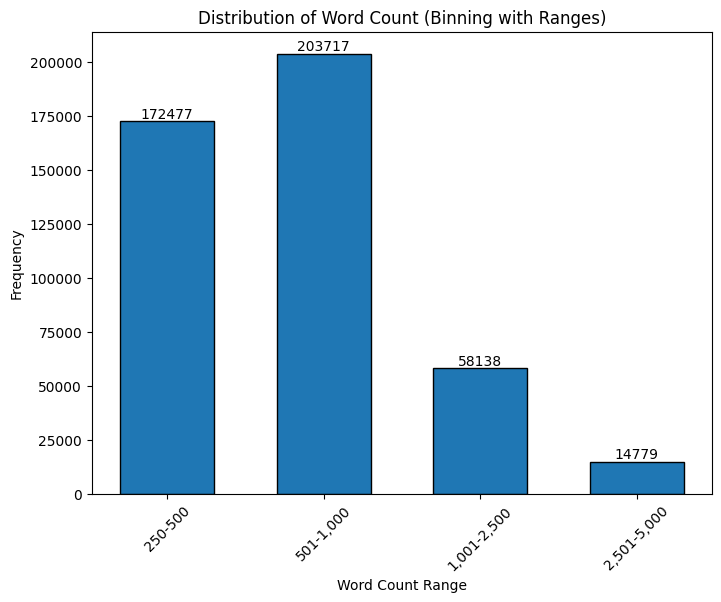

In [16]:
word_count_data = text_df['word_count']

# custom made bins
bins = [250, 500, 1000, 2500, 5000]
bin_labels = ['250-500', '501-1,000', '1,001-2,500', '2,501-5,000']

# create histogram
hist, _ = np.histogram(word_count_data, bins=bins)

# Use a bar chart to plot
plt.figure(figsize=(8, 6))
bars = plt.bar(bin_labels, hist, width=0.6, edgecolor='black')

# Add frequency value on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom', ha='center')

plt.title('Distribution of Word Count (Binning with Ranges)')
plt.xlabel('Word Count Range')
plt.xticks(rotation=45)
plt.ylabel('Frequency')
plt.show()

We can see that there are a lot more essays in the 250-500 word range than any other range within our dataset. Now lets take a look at the distribution and source percentage in respect to the different essay types.

In [17]:
def plot_violin_plus_pie(essay_df, type='ENTER PREDEFINED TYPE'):
    fig, ax = plt.subplots(1, 2, figsize=(9, 5))

    sns.violinplot(data=essay_df, x="word_count", linewidth=.8, linecolor="black", ax=ax[0])
    sns.despine()
    ax[0].set_title('Distribution of Word Count - ' + type)

    source_counts = essay_df['source'].value_counts()
    ax[1].pie(
        source_counts,
        labels = source_counts.index,
        autopct = '%1.1f%%',
        wedgeprops = {'edgecolor': 'black'}
    )
    ax[1].set_title('Percentage of Human and AI Entries - ' + type)

    plt.tight_layout()
    plt.show()

### One-Page Dataset

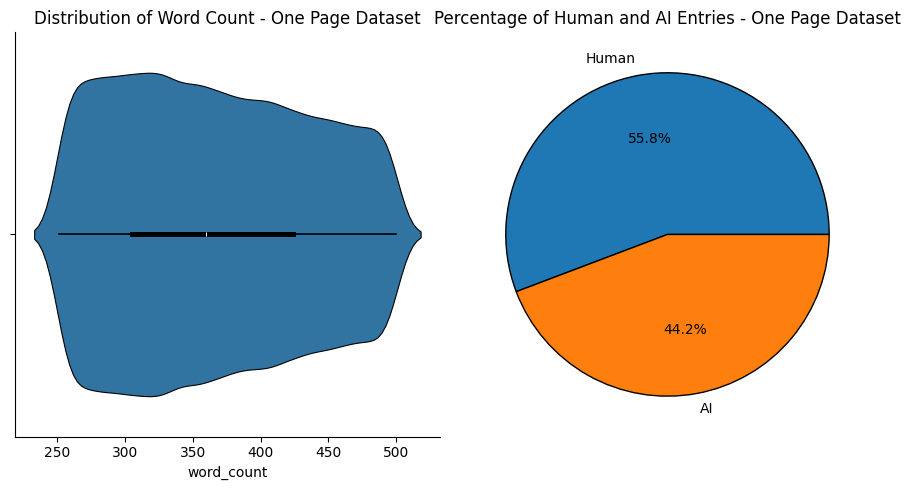

Size of this dataset: (30000, 6)


In [18]:
title = ['Test Dataset', 'One Page Dataset', 'Two Page Dataset', 'Four Page Dataset', 'Long Page Dataset', 'Complete Dataset']

plot_violin_plus_pie(one_essay_df, title[1])
print('Size of this dataset:', one_essay_df.shape)

### Two-Page Dataset

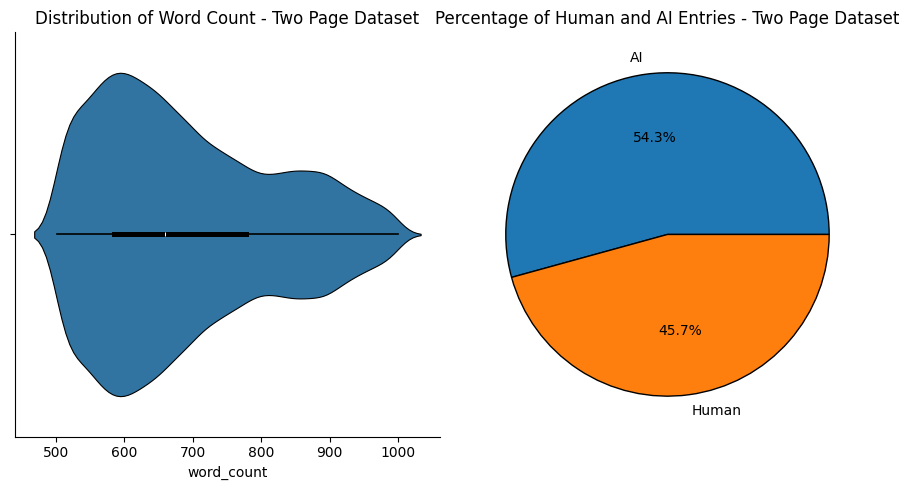

Size of this dataset: (30000, 6)


In [19]:
plot_violin_plus_pie(two_essay_df, title[2])
print('Size of this dataset:', two_essay_df.shape)

### Four-Page Dataset

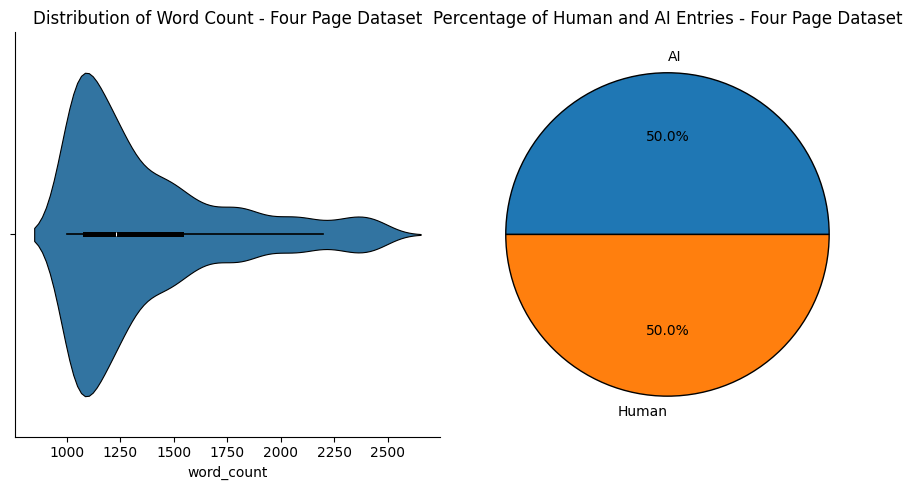

Size of this dataset: (3200, 6)


In [20]:
plot_violin_plus_pie(four_essay_df, title[3])
print('Size of this dataset:', four_essay_df.shape)

### Long Essay Dataset
(more than four pages)

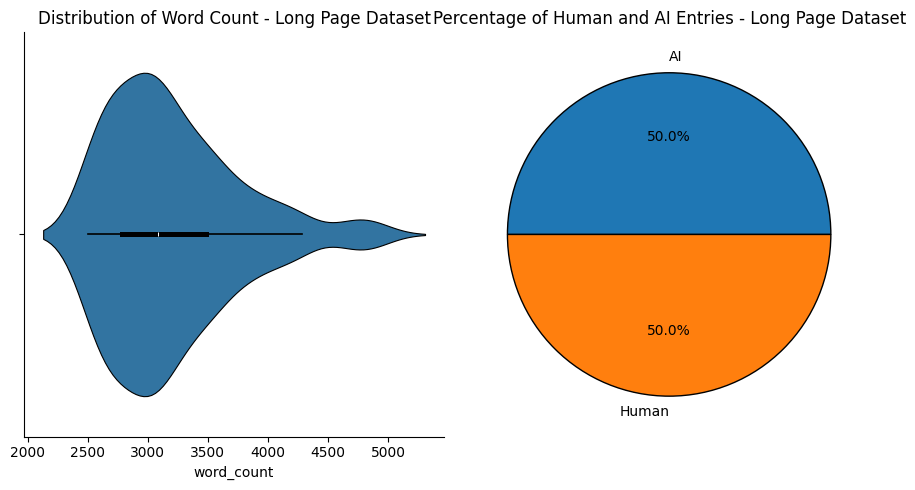

Size of this dataset: (222, 6)


In [21]:
plot_violin_plus_pie(long_essay_df, title[4])
print('Size of this dataset:', long_essay_df.shape)

### Conglomerated Dataset
This is the whole dataset without binning (after being cleaned and preprocessed).

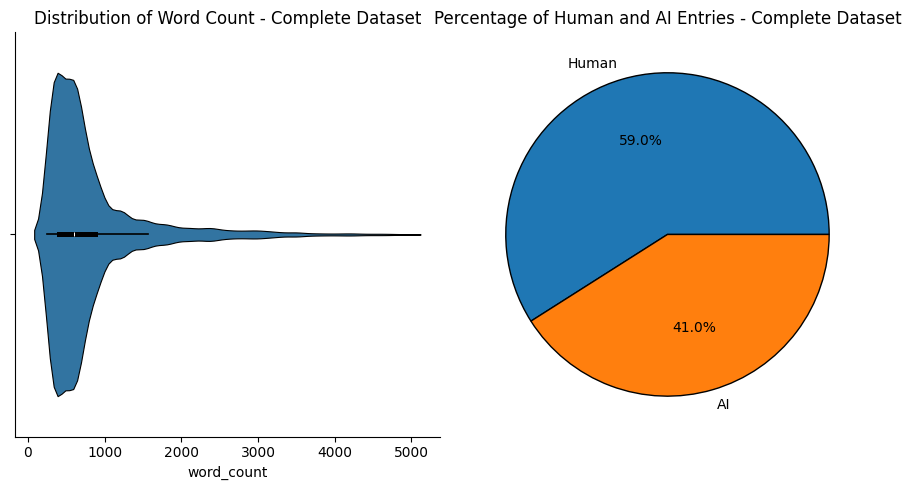

Size of this dataset: (30000, 6)


In [22]:
plot_violin_plus_pie(complete_df, title[5])
print('Size of this dataset:', complete_df.shape)

As we can see, the complete dataset is fairly balanced in terms of the source of the essays. However, the distribution of the word count is still left skewed. 

Lastly, we will remove all features except the ones that we're using, `text` and `label`, since we no longer need them because we are done with data visualization.

In [17]:
# remove the rest of the features we wont be using for the model training: 'text_length' and 'word_count'
one_essay_df.drop(columns=['text_length', 'prompt_id', 'source', 'word_count'], inplace=True)
two_essay_df.drop(columns=['text_length', 'prompt_id', 'source', 'word_count'], inplace=True)
four_essay_df.drop(columns=['text_length', 'prompt_id', 'source', 'word_count'], inplace=True)
long_essay_df.drop(columns=['text_length', 'prompt_id', 'source', 'word_count'], inplace=True)
complete_df.drop(columns=['text_length', 'prompt_id', 'source', 'word_count'], inplace=True)

## 3. Model Architecture Exploration

Here, let's prepare our data further to be fed into the model. First, we want to keep a vocabulary size of 5,000, meaning that only the top 5,000 most frequent words will be used for tokenization. We also will only feed in a sequence that is 1,000 tokens long to our model, pad any inputs that are lower than this length and truncate any inputs longer than this length.

We will then fit the tokenizer on the text data, which will update vocabulary based on the words present in text and assign a unique integer index to each word in the vocabulary.

In [18]:
# vocabulary size
max_word = 5000

# sequences shorter than this padded to reach 1000, sequences longer are truncated
max_sequence_length = 1000

def preprocess_for_models():
    tokenizer = Tokenizer(num_words=max_word, split=' ') 
    tokenizer.fit_on_texts(complete_df['text'].values)
    # converts the text into sequences of integers based on the tokenizer's vocabulary
    X = tokenizer.texts_to_sequences(complete_df['text'].values)
    # pad if needed
    X= pad_sequences(X, maxlen=max_sequence_length)

    y1 = complete_df['label']
    X_train, X_test, y_train, y_test = train_test_split(X,y1, test_size = 0.3, random_state = 42)
    return X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = preprocess_for_models()

Let us define a function to train the model and test it, converting the output to a binary value.

In [19]:
def model_results(model, epochs=2):
    model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test))
    y_pred = model.predict(X_test)
    y_pred_binary = (y_pred > 0.5).astype(int)
    print("Classification Report:")
    print(classification_report(y_test, y_pred_binary))

    return accuracy_score(y_test, y_pred_binary)

We will now begin experimenting with a variety of architectures for our model, printing their outputs, and saving them for later use if necessary. Let us consider model 1 our vanilla model. Each subsequent model will have its deviations from model 1 highlighted in blue.

### Model 1
* Embedding layer
* Bidirectional LSTM (128 units, dropout=0.5)
* Bidirectional LSTM (64 units, dropout=0.5)
* FC layer to 1 (sigmoid activation)

In [77]:
model1 = Sequential()
model1.add(Embedding(max_word, 1000))
model1.add(Bidirectional(LSTM(128, dropout=0.5, return_sequences=True)))
model1.add(Bidirectional(LSTM(64, dropout=0.5)))
model1.add(Dense(1, activation='sigmoid'))

model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_results(model1)
model1.save("model1.keras")

Epoch 1/2
657/657 ━━━━━━━━━━━━━━━━━━━━ 2513s 4s/step - accuracy: 0.8335 - loss: 0.3641 - val_accuracy: 0.8958 - val_loss: 0.2455
Epoch 2/2
657/657 ━━━━━━━━━━━━━━━━━━━━ 2460s 4s/step - accuracy: 0.9204 - loss: 0.1985 - val_accuracy: 0.8633 - val_loss: 0.3395
282/282 ━━━━━━━━━━━━━━━━━━━━ 186s 656ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.68      0.80      3669
           1       0.82      0.99      0.90      5331

    accuracy                           0.86      9000
   macro avg       0.90      0.84      0.85      9000
weighted avg       0.88      0.86      0.86      9000



### Model 2
* Embedding layer
* <span style="color:#0e8fc7">LSTM</span> (128 units, <span style="color:#0e8fc7">dropout=0.2, recurrent dropout=0.2</span>)
* <span style="color:#0e8fc7">LSTM</span> (64 units, <span style="color:#0e8fc7">dropout=0.2, recurrent dropout=0.2</span>)
* FC layer to 1 (sigmoid activation)

In [78]:
model2 = Sequential()

model2.add(Embedding(max_word, 1000))
model2.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model2.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model2.add(Dense(1, activation='sigmoid'))

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_results(model2)
model2.save("model2.keras")

Epoch 1/2
657/657 ━━━━━━━━━━━━━━━━━━━━ 1454s 2s/step - accuracy: 0.8344 - loss: 0.3543 - val_accuracy: 0.8850 - val_loss: 0.2660
Epoch 2/2
657/657 ━━━━━━━━━━━━━━━━━━━━ 1510s 2s/step - accuracy: 0.9141 - loss: 0.2037 - val_accuracy: 0.8971 - val_loss: 0.2458
282/282 ━━━━━━━━━━━━━━━━━━━━ 146s 517ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.84      0.87      3669
           1       0.89      0.94      0.92      5331

    accuracy                           0.90      9000
   macro avg       0.90      0.89      0.89      9000
weighted avg       0.90      0.90      0.90      9000



### Model 3
* Embedding layer
* Bidirectional LSTM (128 units, dropout=0.5)
* Bidirectional LSTM (64 units, dropout=0.5)
* <span style="color:#0e8fc7">FC layer to 64 (relu activation)</span>
* FC layer to 1 (sigmoid activation)

In [79]:
model3 = Sequential()
model3.add(Embedding(max_word, 1000))
model3.add(Bidirectional(LSTM(128, dropout=0.5, return_sequences=True)))
model3.add(Bidirectional(LSTM(64, dropout=0.5)))
model3.add(Dense(64, activation='relu'))
model3.add(Dense(1, activation='sigmoid'))

model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_results(model3)
model3.save("model3.keras")

Epoch 1/2
657/657 ━━━━━━━━━━━━━━━━━━━━ 2527s 4s/step - accuracy: 0.8317 - loss: 0.3642 - val_accuracy: 0.8801 - val_loss: 0.2955
Epoch 2/2
657/657 ━━━━━━━━━━━━━━━━━━━━ 2408s 4s/step - accuracy: 0.8884 - loss: 0.2617 - val_accuracy: 0.9021 - val_loss: 0.2599
282/282 ━━━━━━━━━━━━━━━━━━━━ 164s 580ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.83      0.87      3669
           1       0.89      0.95      0.92      5331

    accuracy                           0.90      9000
   macro avg       0.91      0.89      0.90      9000
weighted avg       0.90      0.90      0.90      9000



### Model 4
* Embedding layer
* Bidirectional LSTM (<span style="color:#0e8fc7">64 units, dropout=0.2, recurrent dropout=0.2</span>)
* Bidirectional LSTM (<span style="color:#0e8fc7">32 units, dropout=0.2, recurrent dropout=0.2</span>)
* FC layer to 1 (sigmoid activation)

In [80]:
model4 = Sequential()
model4.add(Embedding(max_word, 1000))
model4.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
model4.add(Bidirectional(LSTM(32, dropout=0.2, recurrent_dropout=0.2)))
model4.add(Dense(1, activation='sigmoid'))

model4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_results(model4)
model4.save("model4.keras")

Epoch 1/2
657/657 ━━━━━━━━━━━━━━━━━━━━ 1212s 2s/step - accuracy: 0.8270 - loss: 0.3640 - val_accuracy: 0.8926 - val_loss: 0.2410
Epoch 2/2
657/657 ━━━━━━━━━━━━━━━━━━━━ 1265s 2s/step - accuracy: 0.9166 - loss: 0.1964 - val_accuracy: 0.9046 - val_loss: 0.2488
282/282 ━━━━━━━━━━━━━━━━━━━━ 96s 338ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.84      0.88      3669
           1       0.90      0.95      0.92      5331

    accuracy                           0.90      9000
   macro avg       0.91      0.89      0.90      9000
weighted avg       0.91      0.90      0.90      9000



### Model 5
* Embedding layer
* Bidirectional LSTM (128 units, dropout=0.5)
* Bidirectional LSTM (64 units, dropout=0.5)
* <span style="color:#0e8fc7">FC layer to 64 (leaky relu activation)</span>
* FC layer to 1 (sigmoid activation)

In [83]:
model5 = Sequential()
model5.add(Embedding(max_word, 1000))
model5.add(Bidirectional(LSTM(128, dropout=0.5, return_sequences=True)))
model5.add(Bidirectional(LSTM(64, dropout=0.5)))
model5.add(Dense(64, activation=LeakyReLU()))
model5.add(Dense(1, activation='sigmoid'))

model5.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_results(model5)
model5.save("model5.keras")

Epoch 1/2
657/657 ━━━━━━━━━━━━━━━━━━━━ 1859s 3s/step - accuracy: 0.8306 - loss: 0.3559 - val_accuracy: 0.9077 - val_loss: 0.2311
Epoch 2/2
657/657 ━━━━━━━━━━━━━━━━━━━━ 1839s 3s/step - accuracy: 0.9255 - loss: 0.1910 - val_accuracy: 0.9059 - val_loss: 0.2326
282/282 ━━━━━━━━━━━━━━━━━━━━ 160s 565ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.82      0.88      3669
           1       0.88      0.97      0.92      5331

    accuracy                           0.91      9000
   macro avg       0.91      0.89      0.90      9000
weighted avg       0.91      0.91      0.90      9000



### Model 6
* Embedding layer
* Bidirectional LSTM (<span style="color:#0e8fc7">64 units, dropout=0.2, recurrent dropout=0.2</span>)
* Bidirectional LSTM (<span style="color:#0e8fc7">32 units, dropout=0.2, recurrent dropout=0.2</span>)
* <span style="color:#0e8fc7">Bidirectional LSTM (32 units, dropout=0.2, recurrent dropout=0.2</span>)
* <span style="color:#0e8fc7">FC layer to 64 (relu activation)</span>
* FC layer to 1 (sigmoid activation)

In [84]:
model6 = Sequential()
model6.add(Embedding(max_word, 500, input_length=max_sequence_length))
model6.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
model6.add(Bidirectional(LSTM(32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
model6.add(Bidirectional(LSTM(32, dropout=0.2, recurrent_dropout=0.2)))
model6.add(Dense(1, activation='sigmoid'))

model6.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_results(model6)
model6.save("model6.keras")

Epoch 1/2


/Users/moni/CS364M/venv/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


657/657 ━━━━━━━━━━━━━━━━━━━━ 943s 1s/step - accuracy: 0.8249 - loss: 0.3715 - val_accuracy: 0.9020 - val_loss: 0.2416
Epoch 2/2
657/657 ━━━━━━━━━━━━━━━━━━━━ 1056s 2s/step - accuracy: 0.9246 - loss: 0.1838 - val_accuracy: 0.8988 - val_loss: 0.2468
282/282 ━━━━━━━━━━━━━━━━━━━━ 90s 317ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.83      0.87      3669
           1       0.89      0.95      0.92      5331

    accuracy                           0.90      9000
   macro avg       0.90      0.89      0.89      9000
weighted avg       0.90      0.90      0.90      9000



### Model 7
* Embedding layer
* Bidirectional LSTM (<span style="color:#0e8fc7">64 units, dropout=0.2, recurrent dropout=0.2</span>)
* FC layer to 1 (sigmoid activation)

In [85]:
model7 = Sequential()
model7.add(Embedding(max_word, 1000))
model7.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)))
model7.add(Dense(1, activation='sigmoid'))

model7.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_results(model7)
model7.save("model7.keras")

Epoch 1/2
657/657 ━━━━━━━━━━━━━━━━━━━━ 1164s 2s/step - accuracy: 0.8109 - loss: 0.3832 - val_accuracy: 0.8890 - val_loss: 0.2586
Epoch 2/2
657/657 ━━━━━━━━━━━━━━━━━━━━ 1315s 2s/step - accuracy: 0.9100 - loss: 0.2127 - val_accuracy: 0.9008 - val_loss: 0.2413
282/282 ━━━━━━━━━━━━━━━━━━━━ 83s 293ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      3669
           1       0.91      0.92      0.92      5331

    accuracy                           0.90      9000
   macro avg       0.90      0.90      0.90      9000
weighted avg       0.90      0.90      0.90      9000



### Model 8
* Embedding layer
* Bidirectional LSTM (128 units, dropout=0.5)
* Bidirectional <span style="color:#0e8fc7">GRU</span> (64 units, dropout=0.5)
* FC layer to 1 (sigmoid activation)

In [88]:
model8 = Sequential()
model8.add(Embedding(max_word, 1000))
model8.add(Bidirectional(LSTM(128, dropout=0.5, return_sequences=True)))
model8.add(Bidirectional(GRU(64, dropout=0.5, return_sequences=False)))
model8.add(Dense(1, activation='sigmoid'))

model8.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_results(model8)
model8.save("model8.keras")

Epoch 1/2
657/657 ━━━━━━━━━━━━━━━━━━━━ 2360s 4s/step - accuracy: 0.8120 - loss: 0.3870 - val_accuracy: 0.9140 - val_loss: 0.2074
Epoch 2/2
657/657 ━━━━━━━━━━━━━━━━━━━━ 2225s 3s/step - accuracy: 0.9293 - loss: 0.1703 - val_accuracy: 0.9271 - val_loss: 0.1787
282/282 ━━━━━━━━━━━━━━━━━━━━ 225s 793ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      3669
           1       0.94      0.94      0.94      5331

    accuracy                           0.93      9000
   macro avg       0.93      0.92      0.92      9000
weighted avg       0.93      0.93      0.93      9000



### Model 9
* Embedding layer
* Bidirectional LSTM (128 units, dropout=0.5)
* <span style="color:#0e8fc7">Layer normalization</span>
* Bidirectional LSTM (64 units, dropout=0.5)
* <span style="color:#0e8fc7">Layer normalization</span>
* FC layer to 1 (sigmoid activation)

In [91]:
model9 = Sequential()
model9.add(Embedding(max_word, 1000))
model9.add(Bidirectional(LSTM(128, dropout=0.5, return_sequences=True)))
model9.add(LayerNormalization())
model9.add(Bidirectional(LSTM(64, dropout=0.5)))
model9.add(LayerNormalization())
model9.add(Dense(1, activation='sigmoid'))

model9.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_results(model9)
model9.save("model9.keras")

Epoch 1/2
657/657 ━━━━━━━━━━━━━━━━━━━━ 2218s 3s/step - accuracy: 0.8224 - loss: 0.3880 - val_accuracy: 0.8767 - val_loss: 0.2752
Epoch 2/2
657/657 ━━━━━━━━━━━━━━━━━━━━ 2026s 3s/step - accuracy: 0.9036 - loss: 0.2285 - val_accuracy: 0.9017 - val_loss: 0.2524
282/282 ━━━━━━━━━━━━━━━━━━━━ 176s 621ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.84      0.87      3669
           1       0.90      0.94      0.92      5331

    accuracy                           0.90      9000
   macro avg       0.90      0.89      0.90      9000
weighted avg       0.90      0.90      0.90      9000



### Model 10
* Embedding layer
* Bidirectional LSTM (<span style="color:#0e8fc7">256</span> units, dropout=0.5)
* Bidirectional LSTM (<span style="color:#0e8fc7">128</span> units, dropout=0.5)
* FC layer to 1 (sigmoid activation)

In [95]:
model10 = Sequential()
model10.add(Embedding(max_word, 1000))
model10.add(Bidirectional(LSTM(256, dropout=0.5, return_sequences=True)))
model10.add(Bidirectional(LSTM(128, dropout=0.5)))
model10.add(Dense(1, activation='sigmoid'))

model10.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_results(model10)
model10.save("model10.keras")

Epoch 1/2
657/657 ━━━━━━━━━━━━━━━━━━━━ 4501s 7s/step - accuracy: 0.8329 - loss: 0.3605 - val_accuracy: 0.8913 - val_loss: 0.2567
Epoch 2/2
657/657 ━━━━━━━━━━━━━━━━━━━━ 4945s 8s/step - accuracy: 0.9213 - loss: 0.1956 - val_accuracy: 0.9009 - val_loss: 0.2571
282/282 ━━━━━━━━━━━━━━━━━━━━ 489s 2s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.81      0.87      3669
           1       0.88      0.97      0.92      5331

    accuracy                           0.90      9000
   macro avg       0.91      0.89      0.89      9000
weighted avg       0.90      0.90      0.90      9000



Now, we will take the best model architecture from the 10 different variations we have explored (model 8) to use it on variations of the dataset by essay length.

### Model 11
* Embedding layer
* Bidirectional LSTM (<span style="color:#0e8fc7">64</span> units, dropout=0.5)
* Bidirectional LSTM (<span style="color:#0e8fc7">32</span> units, dropout=0.5)
* FC layer to 1 (sigmoid activation)

In [29]:
model11 = Sequential()
model11.add(Embedding(max_word, 1000))
model11.add(Bidirectional(LSTM(64, dropout=0.5, return_sequences=True)))
model11.add(Bidirectional(LSTM(32, dropout=0.5)))
model11.add(Dense(1, activation='sigmoid'))

model11.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_results(model11)
model11.save("model11.keras")

Epoch 1/2
657/657 ━━━━━━━━━━━━━━━━━━━━ 1301s 2s/step - accuracy: 0.8345 - loss: 0.3587 - val_accuracy: 0.9043 - val_loss: 0.2459
Epoch 2/2
657/657 ━━━━━━━━━━━━━━━━━━━━ 1406s 2s/step - accuracy: 0.9262 - loss: 0.1799 - val_accuracy: 0.9023 - val_loss: 0.2414
282/282 ━━━━━━━━━━━━━━━━━━━━ 92s 325ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.87      0.91      4956
           1       0.86      0.94      0.90      4044

    accuracy                           0.90      9000
   macro avg       0.90      0.91      0.90      9000
weighted avg       0.91      0.90      0.90      9000



### Model 12
* <span style="color:#0e8fc7">one page essay dataset</span>
* Embedding layer
* Bidirectional LSTM (128 units, dropout=0.5)
* Bidirectional <span style="color:#0e8fc7">GRU</span> (64 units, dropout=0.5)
* FC layer to 1 (sigmoid activation)

In [27]:
tokenizer = Tokenizer(num_words=max_word, split=' ') 
tokenizer.fit_on_texts(one_essay_df['text'].values)
# converts the text into sequences of integers based on the tokenizer's vocabulary
X = tokenizer.texts_to_sequences(one_essay_df['text'].values)
# pad if needed
X= pad_sequences(X, maxlen=max_sequence_length)

y1 = one_essay_df['label']
X_train, X_test, y_train, y_test = train_test_split(X,y1, test_size = 0.3, random_state = 42)

model12 = Sequential()
model12.add(Embedding(max_word, 1000))
model12.add(Bidirectional(LSTM(128, dropout=0.5, return_sequences=True)))
model12.add(Bidirectional(GRU(64, dropout=0.5, return_sequences=False)))
model12.add(Dense(1, activation='sigmoid'))

model12.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_results(model12)
model12.save("model12.keras")

Epoch 1/2
657/657 ━━━━━━━━━━━━━━━━━━━━ 1734s 3s/step - accuracy: 0.8014 - loss: 0.4195 - val_accuracy: 0.8838 - val_loss: 0.2816
Epoch 2/2
657/657 ━━━━━━━━━━━━━━━━━━━━ 1726s 3s/step - accuracy: 0.9119 - loss: 0.2313 - val_accuracy: 0.8873 - val_loss: 0.2657
282/282 ━━━━━━━━━━━━━━━━━━━━ 159s 564ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.83      0.87      3935
           1       0.88      0.93      0.90      5065

    accuracy                           0.89      9000
   macro avg       0.89      0.88      0.88      9000
weighted avg       0.89      0.89      0.89      9000



### Model 13
* <span style="color:#0e8fc7">two page essay dataset</span>
* Embedding layer
* Bidirectional LSTM (128 units, dropout=0.5)
* Bidirectional <span style="color:#0e8fc7">GRU</span> (64 units, dropout=0.5)
* FC layer to 1 (sigmoid activation)

In [28]:
tokenizer = Tokenizer(num_words=max_word, split=' ') 
tokenizer.fit_on_texts(two_essay_df['text'].values)
# converts the text into sequences of integers based on the tokenizer's vocabulary
X = tokenizer.texts_to_sequences(two_essay_df['text'].values)
# pad if needed
X= pad_sequences(X, maxlen=max_sequence_length)

y1 = two_essay_df['label']
X_train, X_test, y_train, y_test = train_test_split(X,y1, test_size = 0.3, random_state = 42)

model13 = Sequential()
model13.add(Embedding(max_word, 1000))
model13.add(Bidirectional(LSTM(128, dropout=0.5, return_sequences=True)))
model13.add(Bidirectional(GRU(64, dropout=0.5, return_sequences=False)))
model13.add(Dense(1, activation='sigmoid'))

model13.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_results(model13)
model13.save("model13.keras")

Epoch 1/2
657/657 ━━━━━━━━━━━━━━━━━━━━ 1756s 3s/step - accuracy: 0.8384 - loss: 0.3353 - val_accuracy: 0.9201 - val_loss: 0.1956
Epoch 2/2
657/657 ━━━━━━━━━━━━━━━━━━━━ 1759s 3s/step - accuracy: 0.9422 - loss: 0.1498 - val_accuracy: 0.9421 - val_loss: 0.1552
282/282 ━━━━━━━━━━━━━━━━━━━━ 171s 606ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      4870
           1       0.95      0.93      0.94      4130

    accuracy                           0.94      9000
   macro avg       0.94      0.94      0.94      9000
weighted avg       0.94      0.94      0.94      9000



### Model 14
* <span style="color:#0e8fc7">four page essay dataset</span>
* Embedding layer
* Bidirectional LSTM (128 units, dropout=0.5)
* Bidirectional <span style="color:#0e8fc7">GRU</span> (64 units, dropout=0.5)
* FC layer to 1 (sigmoid activation)

In [29]:
tokenizer = Tokenizer(num_words=max_word, split=' ') 
tokenizer.fit_on_texts(four_essay_df['text'].values)
# converts the text into sequences of integers based on the tokenizer's vocabulary
X = tokenizer.texts_to_sequences(four_essay_df['text'].values)
# pad if needed
X= pad_sequences(X, maxlen=max_sequence_length)

y1 = four_essay_df['label']
X_train, X_test, y_train, y_test = train_test_split(X,y1, test_size = 0.3, random_state = 42)

model14 = Sequential()
model14.add(Embedding(max_word, 1000))
model14.add(Bidirectional(LSTM(128, dropout=0.5, return_sequences=True)))
model14.add(Bidirectional(GRU(64, dropout=0.5, return_sequences=False)))
model14.add(Dense(1, activation='sigmoid'))

model14.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_results(model14)
model14.save("model14.keras")

Epoch 1/2
70/70 ━━━━━━━━━━━━━━━━━━━━ 167s 2s/step - accuracy: 0.8021 - loss: 0.3806 - val_accuracy: 0.9604 - val_loss: 0.1176
Epoch 2/2
70/70 ━━━━━━━━━━━━━━━━━━━━ 173s 2s/step - accuracy: 0.9923 - loss: 0.0413 - val_accuracy: 0.9594 - val_loss: 0.1101
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 635ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       488
           1       0.96      0.96      0.96       472

    accuracy                           0.96       960
   macro avg       0.96      0.96      0.96       960
weighted avg       0.96      0.96      0.96       960



### Model 15
* <span style="color:#0e8fc7">long page essay dataset</span>
* Embedding layer
* Bidirectional LSTM (128 units, dropout=0.5)
* Bidirectional <span style="color:#0e8fc7">GRU</span> (64 units, dropout=0.5)
* FC layer to 1 (sigmoid activation)

In [62]:
tokenizer = Tokenizer(num_words=max_word, split=' ') 
tokenizer.fit_on_texts(long_essay_df['text'].values)
# converts the text into sequences of integers based on the tokenizer's vocabulary
X = tokenizer.texts_to_sequences(long_essay_df['text'].values)
# pad if needed
X= pad_sequences(X, maxlen=max_sequence_length)

y1 = long_essay_df['label']
X_train, X_test, y_train, y_test = train_test_split(X,y1, test_size = 0.3, random_state = 42)

model15 = Sequential()
model15.add(Embedding(max_word, 1000))
model15.add(Bidirectional(LSTM(128, dropout=0.5, return_sequences=True)))
model15.add(Bidirectional(GRU(64, dropout=0.5, return_sequences=False)))
model15.add(Dense(1, activation='sigmoid'))

model15.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_results(model15)
model15.save("model15.keras")

Epoch 1/2
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.5734 - loss: 0.6891 - val_accuracy: 0.8358 - val_loss: 0.6596
Epoch 2/2
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - accuracy: 0.9965 - loss: 0.6046 - val_accuracy: 0.9552 - val_loss: 0.4823
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/stepWARNING:tensorflow:5 out of the last 25 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x3bca527a0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more detai

## 4. Ensembling

### Using Models Trained on Essay Length

Now, let us see if we can strengthen our accuracies by using ensembling. First, let's take a look at the models that were trained on subsets of the dataset, specifically models 11-15. Let's take make ensembles on all 4 of these models.

First, let us do weighted average ensembling. We will use the accuracies of each model as weights.

In [73]:
# reset our dataset and specifically the test set and labels back to complete_df
X_train, X_test, y_train, y_test = preprocess_for_models()

# get the predictions of every model on the test set
pred_model12 = model12.predict(X_test)
pred_model13 = model13.predict(X_test)
pred_model14 = model14.predict(X_test)
pred_model15 = model15.predict(X_test)

# save accuracies for each model
accuracies = [0.89, 0.94, 0.96, 0.96]

# weight predictions by model accuracy
weighted_pred = np.average([pred_model12, pred_model13, pred_model14, pred_model15], axis=0, weights=accuracies)

# if all voted above 0.5, consider it a 1
threshold = 0.5
final_pred = (weighted_pred > threshold).astype(int)

print("Classification Report:")
print(classification_report(y_test, final_pred))

282/282 ━━━━━━━━━━━━━━━━━━━━ 176s 625ms/step
282/282 ━━━━━━━━━━━━━━━━━━━━ 194s 688ms/step
282/282 ━━━━━━━━━━━━━━━━━━━━ 176s 623ms/step
282/282 ━━━━━━━━━━━━━━━━━━━━ 168s 596ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.79      0.55      3713
           1       0.60      0.22      0.33      5287

    accuracy                           0.46      9000
   macro avg       0.51      0.51      0.44      9000
weighted avg       0.53      0.46      0.42      9000



Let us repeat the weighted average ensembling, but now we will use the proportion of samples that each model trained on as weights, with the idea that models that trained on more samples will be more accurate.

In [74]:
# weight by number of samples that each model trained on
accuracies = [len(one_essay_df)/len(complete_df), len(two_essay_df)/len(complete_df), len(four_essay_df)/len(complete_df), len(long_essay_df)/len(complete_df)]

# weight predictions
weighted_pred = np.average([pred_model12, pred_model13, pred_model14, pred_model15], axis=0, weights=accuracies)

# if all voted above 0.5, consider it a 1
threshold = 0.5
final_pred = (weighted_pred > threshold).astype(int)

print("Classification Report:")
print(classification_report(y_test, final_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.74      0.54      3713
           1       0.63      0.31      0.41      5287

    accuracy                           0.48      9000
   macro avg       0.53      0.52      0.48      9000
weighted avg       0.54      0.48      0.46      9000



Now, let us do hard voting. We will take the predictions of each model and take a popular vote amongst them.

In [83]:
# find the predictions of all models
pred_model12 = (pred_model12 > 0.5).astype(int)
pred_model13 = (pred_model13 > 0.5).astype(int)
pred_model14 = (pred_model14 > 0.5).astype(int)
pred_model15 = (pred_model15 > 0.5).astype(int)

# combining predictions into a single array
arrays = [pred_model12, pred_model13, pred_model14, pred_model15]
arrays_np = np.array(arrays)

# calculate the majority value along columns
majority_values = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=arrays_np)

print("Classification Report:")
print(classification_report(y_test, majority_values))

Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.95      0.57      3713
           1       0.58      0.05      0.09      5287

    accuracy                           0.42      9000
   macro avg       0.50      0.50      0.33      9000
weighted avg       0.51      0.42      0.29      9000



### Using Models with Best Accuracy

Now, let us repeat the two ensembling methods we used, but this time using our best performing models in terms of accuracy. We will repeat this using our top 5 models (4, 5, 7, 8, 11), and our top 3 models (5, 8, 11) (only selecting from models 1-11, which were trained on the complete dataset).

First, let us do weighted average ensembling with our top 5 best models.

In [32]:
# get the predictions of every model on the test set
pred_model4 = model4.predict(X_test)
pred_model5 = model5.predict(X_test)
pred_model7 = model7.predict(X_test)
pred_model8 = model8.predict(X_test)
pred_model11 = model11.predict(X_test)

# save accuracies for each model
accuracies = [90, 91, 90, 93, 90]

# weight predictions by model accuracy
weighted_pred = np.average([pred_model4, pred_model5, pred_model7, pred_model8, pred_model11], axis=0, weights=accuracies)

# if all voted above 0.5, consider it a 1
threshold = 0.5
final_pred = (weighted_pred > threshold).astype(int)

print("Classification Report:")
print(classification_report(y_test, final_pred))

282/282 ━━━━━━━━━━━━━━━━━━━━ 87s 306ms/step
282/282 ━━━━━━━━━━━━━━━━━━━━ 158s 562ms/step
282/282 ━━━━━━━━━━━━━━━━━━━━ 70s 249ms/step
282/282 ━━━━━━━━━━━━━━━━━━━━ 164s 582ms/step
282/282 ━━━━━━━━━━━━━━━━━━━━ 92s 326ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.87      0.89      3668
           1       0.91      0.94      0.93      5332

    accuracy                           0.91      9000
   macro avg       0.91      0.91      0.91      9000
weighted avg       0.91      0.91      0.91      9000



Now, let us do hard voting ensembling with our top 5 best models.

In [33]:
# find the predictions of all models
pred_model4 = (pred_model4 > 0.5).astype(int)
pred_model5 = (pred_model5 > 0.5).astype(int)
pred_model7 = (pred_model7 > 0.5).astype(int)
pred_model8 = (pred_model8 > 0.5).astype(int)
pred_model11 = (pred_model11 > 0.5).astype(int)

# combining predictions into a single array
arrays = [pred_model4, pred_model5, pred_model7, pred_model8, pred_model11]
arrays_np = np.array(arrays)

# calculate the majority value along columns
majority_values = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=arrays_np)

print("Classification Report:")
print(classification_report(y_test, majority_values))

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.87      0.89      3668
           1       0.91      0.94      0.93      5332

    accuracy                           0.91      9000
   macro avg       0.91      0.90      0.91      9000
weighted avg       0.91      0.91      0.91      9000



Let us do weighted average ensembling with our top 3 best models.

In [36]:
# save accuracies for each model
accuracies = [91, 93, 90]

# weight predictions by model accuracy
weighted_pred = np.average([ pred_model5, pred_model8, pred_model11], axis=0, weights=accuracies)

# if all voted above 0.5, consider it a 1
threshold = 0.5
final_pred = (weighted_pred > threshold).astype(int)

print("Classification Report:")
print(classification_report(y_test, final_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.87      0.89      3668
           1       0.92      0.94      0.93      5332

    accuracy                           0.91      9000
   macro avg       0.91      0.91      0.91      9000
weighted avg       0.91      0.91      0.91      9000



Let us do hard voting ensembling with our top 3 best models.

In [35]:
# find the predictions of all models
pred_model5 = (pred_model5 > 0.5).astype(int)
pred_model8 = (pred_model8 > 0.5).astype(int)
pred_model11 = (pred_model11 > 0.5).astype(int)

# combining predictions into a single array
arrays = [pred_model5, pred_model8, pred_model11]
arrays_np = np.array(arrays)

# calculate the majority value along columns
majority_values = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=arrays_np)

print("Classification Report:")
print(classification_report(y_test, majority_values))

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.87      0.89      3668
           1       0.92      0.94      0.93      5332

    accuracy                           0.91      9000
   macro avg       0.91      0.91      0.91      9000
weighted avg       0.91      0.91      0.91      9000



## 5. Fine-Tuning Our Top-Performing Model

Now, let us take our best-performing model from the 11 that we trained on the entire dataset to see if we can improve it in any way. We will see if making changes to the vocabulary size and input length have any effect on the model accuracy.

We will do this by first increasing the maximum vocabulary size while keeping input length constant.

In [38]:
# vocabulary size
max_word = 7500

# sequences shorter than this padded to reach 1000, sequences longer are truncated
max_sequence_length = 1000

X_train, X_test, y_train, y_test = preprocess_for_models()

In [39]:
model8_1 = Sequential()
model8_1.add(Embedding(max_word, 1000))
model8_1.add(Bidirectional(LSTM(128, dropout=0.5, return_sequences=True)))
model8_1.add(Bidirectional(GRU(64, dropout=0.5, return_sequences=False)))
model8_1.add(Dense(1, activation='sigmoid'))

model8_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_results(model8_1)
model8_1.save("model8_1.keras")

Epoch 1/2
657/657 ━━━━━━━━━━━━━━━━━━━━ 1965s 3s/step - accuracy: 0.8303 - loss: 0.3587 - val_accuracy: 0.8988 - val_loss: 0.2537
Epoch 2/2
657/657 ━━━━━━━━━━━━━━━━━━━━ 2080s 3s/step - accuracy: 0.9253 - loss: 0.1872 - val_accuracy: 0.9033 - val_loss: 0.2324
282/282 ━━━━━━━━━━━━━━━━━━━━ 196s 693ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.89      0.88      3668
           1       0.92      0.91      0.92      5332

    accuracy                           0.90      9000
   macro avg       0.90      0.90      0.90      9000
weighted avg       0.90      0.90      0.90      9000



Next, we will increase input length while keeping vocabulary size constant.

In [40]:
# vocabulary size
max_word = 5000

# sequences shorter than this padded to reach 1000, sequences longer are truncated
max_sequence_length = 3000

X_train, X_test, y_train, y_test = preprocess_for_models()

In [43]:
model8_2 = Sequential()
model8_2.add(Embedding(max_word, 1000))
model8_2.add(Bidirectional(LSTM(128, dropout=0.5, return_sequences=True)))
model8_2.add(Bidirectional(GRU(64, dropout=0.5, return_sequences=False)))
model8_2.add(Dense(1, activation='sigmoid'))

model8_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_results(model8_2)
model8_2.save("model8_2.keras")

Epoch 1/2
657/657 ━━━━━━━━━━━━━━━━━━━━ 5714s 9s/step - accuracy: 0.8277 - loss: 0.3662 - val_accuracy: 0.8939 - val_loss: 0.2567
Epoch 2/2
657/657 ━━━━━━━━━━━━━━━━━━━━ 5780s 9s/step - accuracy: 0.9145 - loss: 0.2068 - val_accuracy: 0.9018 - val_loss: 0.2452
282/282 ━━━━━━━━━━━━━━━━━━━━ 476s 2s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.84      0.87      3668
           1       0.89      0.95      0.92      5332

    accuracy                           0.90      9000
   macro avg       0.90      0.89      0.90      9000
weighted avg       0.90      0.90      0.90      9000



Then, we will increase both vocabulary size and maximum input length.

In [44]:
# vocabulary size
max_word = 7500

# sequences shorter than this padded to reach 1000, sequences longer are truncated
max_sequence_length = 3000

X_train, X_test, y_train, y_test = preprocess_for_models()

In [45]:
model8_3 = Sequential()
model8_3.add(Embedding(max_word, 1000))
model8_3.add(Bidirectional(LSTM(128, dropout=0.5, return_sequences=True)))
model8_3.add(Bidirectional(GRU(64, dropout=0.5, return_sequences=False)))
model8_3.add(Dense(1, activation='sigmoid'))

model8_3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_results(model8_3)
model8_3.save("model8_3.keras")

Epoch 1/2


657/657 ━━━━━━━━━━━━━━━━━━━━ 5837s 9s/step - accuracy: 0.8373 - loss: 0.3465 - val_accuracy: 0.8952 - val_loss: 0.2551
Epoch 2/2
657/657 ━━━━━━━━━━━━━━━━━━━━ 5961s 9s/step - accuracy: 0.9321 - loss: 0.1767 - val_accuracy: 0.9050 - val_loss: 0.2350
282/282 ━━━━━━━━━━━━━━━━━━━━ 478s 2s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.83      0.88      3668
           1       0.89      0.96      0.92      5332

    accuracy                           0.91      9000
   macro avg       0.91      0.89      0.90      9000
weighted avg       0.91      0.91      0.90      9000



Lastly, we will decrease vocabulary size and maximum input length.

In [46]:
# vocabulary size
max_word = 3500

# sequences shorter than this padded to reach 1000, sequences longer are truncated
max_sequence_length = 500

X_train, X_test, y_train, y_test = preprocess_for_models()

In [47]:
model8_4 = Sequential()
model8_4.add(Embedding(max_word, 1000))
model8_4.add(Bidirectional(LSTM(128, dropout=0.5, return_sequences=True)))
model8_4.add(Bidirectional(GRU(64, dropout=0.5, return_sequences=False)))
model8_4.add(Dense(1, activation='sigmoid'))

model8_4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_results(model8_4)
model8_4.save("model8_4.keras")

Epoch 1/2


657/657 ━━━━━━━━━━━━━━━━━━━━ 760s 1s/step - accuracy: 0.8370 - loss: 0.3515 - val_accuracy: 0.8961 - val_loss: 0.2412
Epoch 2/2
657/657 ━━━━━━━━━━━━━━━━━━━━ 774s 1s/step - accuracy: 0.9271 - loss: 0.1767 - val_accuracy: 0.9172 - val_loss: 0.2044
282/282 ━━━━━━━━━━━━━━━━━━━━ 76s 269ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      3668
           1       0.92      0.94      0.93      5332

    accuracy                           0.92      9000
   macro avg       0.92      0.91      0.91      9000
weighted avg       0.92      0.92      0.92      9000



Finally, let us increase the number of epochs the model trains for. Because with a reduced vocabulary and input length, the model performed almost just as well as the original model 8 we were testing, we will train with more epochs (7 total) on this model in the interest of reducing computational cost.

In [49]:
model8_5 = Sequential()
model8_5.add(Embedding(max_word, 1000))
model8_5.add(Bidirectional(LSTM(128, dropout=0.5, return_sequences=True)))
model8_5.add(Bidirectional(GRU(64, dropout=0.5, return_sequences=False)))
model8_5.add(Dense(1, activation='sigmoid'))

model8_5.compiLle(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_results(model8_5, epochs=7)
model8_5.save("model8_5.keras")

Epoch 1/7
657/657 ━━━━━━━━━━━━━━━━━━━━ 784s 1s/step - accuracy: 0.8312 - loss: 0.3570 - val_accuracy: 0.8886 - val_loss: 0.2588
Epoch 2/7
657/657 ━━━━━━━━━━━━━━━━━━━━ 782s 1s/step - accuracy: 0.9224 - loss: 0.1900 - val_accuracy: 0.8970 - val_loss: 0.2444
Epoch 3/7
657/657 ━━━━━━━━━━━━━━━━━━━━ 789s 1s/step - accuracy: 0.9449 - loss: 0.1405 - val_accuracy: 0.9094 - val_loss: 0.2285
Epoch 4/7
657/657 ━━━━━━━━━━━━━━━━━━━━ 776s 1s/step - accuracy: 0.9621 - loss: 0.1006 - val_accuracy: 0.9074 - val_loss: 0.2542
Epoch 5/7
657/657 ━━━━━━━━━━━━━━━━━━━━ 785s 1s/step - accuracy: 0.9737 - loss: 0.0696 - val_accuracy: 0.9111 - val_loss: 0.2790
Epoch 6/7
657/657 ━━━━━━━━━━━━━━━━━━━━ 782s 1s/step - accuracy: 0.9809 - loss: 0.0525 - val_accuracy: 0.9117 - val_loss: 0.3213
Epoch 7/7
657/657 ━━━━━━━━━━━━━━━━━━━━ 853s 1s/step - accuracy: 0.9895 - loss: 0.0308 - val_accuracy: 0.9021 - val_loss: 0.3369
282/282 ━━━━━━━━━━━━━━━━━━━━ 79s 278ms/step
Classification Report:
              precision    recall  f1